In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Parameters chosen below to roughly match those from `M64.ipynb`.

In [2]:
import arviz as az
from edge_photometry import edge_model, jax_prng_key
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro 
from numpyro.infer import NUTS, MCMC
import pandas as pd
import seaborn as sns

numpyro.enable_x64()
numpyro.set_host_device_count(4)

sns.set_context('notebook')

In [3]:
def mock_Ierr(I):
    return min(np.exp(-1.68417623 + I*(-0.83340292 + I*0.03069122)), 0.22)
def mock_Verr(V):
    return min(np.exp(-0.675311 + V*(-0.91566766 + V*0.03140466)), 0.44)

Now let's make some mock data.  We draw $A_0 \sim N(0,1)$, and $A_1 = A_0 + 0.5 + 0.2 * N(0,1)$, and $A_2 = A_0 - 0.2 + 0.5*N(0,1)$, subject to the edge constraint.  Thus 
$$
\Sigma = \begin{pmatrix}
1 & 1 & 1 \\
1 & 1.04 & 1 \\
1 & 1 & 1.25
\end{pmatrix}
$$

Our background distribution is considerably wider.

In [4]:
Nfg = 2000
Nbg = int(round(0.2*Nfg))
N = Nfg+Nbg
Nband = 2

c = -0.2
w = np.array([1-c, c])

c_mu = c
c_sigma = 0.01

mu_fg = np.array([26.67723621, 27.97451744])
mu_bg = np.array([27.20254412, 28.14396283])

cov_fg = np.array([[0.2458232 , 0.07516468],
                   [0.07516468, 0.11566182]])
scale_fg = np.sqrt(np.diag(cov_fg))
cov_bg = np.array([[2.4916991 , 2.25207977],
                   [2.25207977, 2.62333206]])
scale_bg = np.sqrt(np.diag(cov_bg))

corr_fg = cov_fg / (scale_fg[:,None]*scale_fg[None,:])
corr_bg = cov_bg / (scale_bg[:,None]*scale_bg[None,:])

chol_corr_fg = np.linalg.cholesky(corr_fg)
chol_corr_bg = np.linalg.cholesky(corr_bg)

c_centered = 1.23
edge_centered = 25.68
e_mu = edge_centered
e_sigma = 0.1

A0_cut = 27.0

Aobs = []
sigma_obs = []
nf = 0
while nf < Nfg:
    A = np.random.multivariate_normal(mu_fg, cov_fg)
    e = A[0] + np.dot(c, (A[1:] - A[:-1] - c_centered))
    if e < edge_centered:
        pass
    else:
        so = np.array([mock_Ierr(A[0]), mock_Verr(A[1])])
        Ao = A + so*np.random.randn(Nband)
        if Ao[0] < A0_cut:
            Aobs.append(Ao)
            sigma_obs.append(so)
            nf += 1

nb = 0
while nb < Nbg:
    A = np.random.multivariate_normal(mu_bg, cov_bg)
    so = np.array([mock_Ierr(A[0]), mock_Verr(A[1])])
    Ao = A + so*np.random.randn(Nband)
    if Ao[0] < A0_cut:
        Aobs.append(Ao)
        sigma_obs.append(so)
        nb += 1
Aobs = np.array(Aobs)
sigma_obs = np.array(sigma_obs)

The foreground component, and the "edge" is clearly visible in the below corner plot:

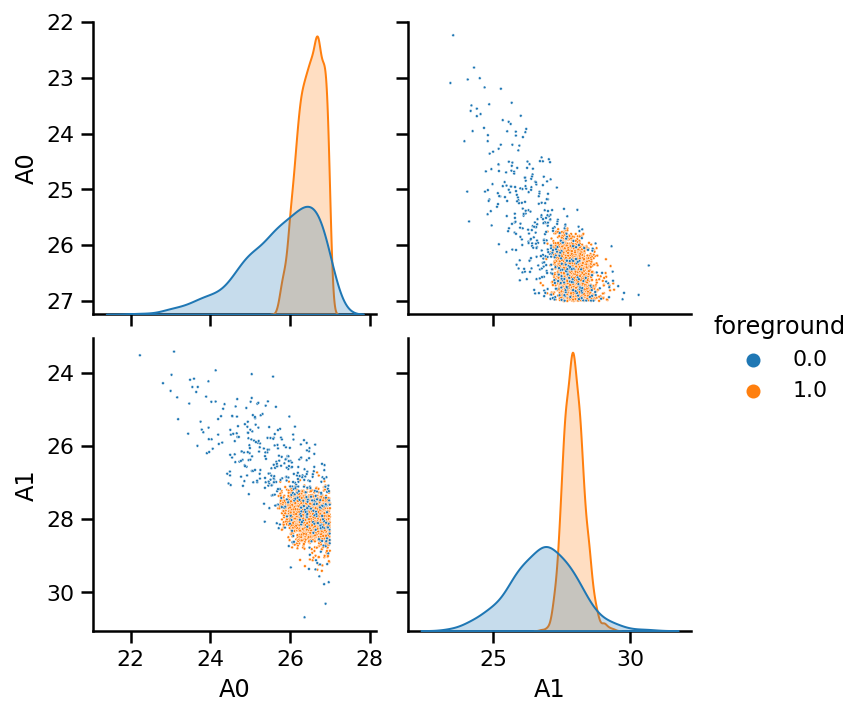

In [5]:
df = pd.DataFrame(Aobs, columns=['A0', 'A1'])
df['foreground'] = np.concatenate((np.ones(Nfg), np.zeros(Nbg)))
#sns.pairplot(df.loc[df['foreground']==1], diag_kws={'common_norm': False})
pg = sns.pairplot(df, hue='foreground', diag_kws={'common_norm': False}, plot_kws={'marker': '.', 's': 8})

for i in range(Nband):
    xl, xh = pg.axes[i,i].get_xlim()
    pg.axes[i,i].set_xlim(xh, xl)
for i in range(Nband):
    for j in range(Nband):
        if not (i == j):
            xl, xh = pg.axes[i,j].get_xlim()
            yl, yh = pg.axes[i,j].get_ylim()

            pg.axes[i,j].set_xlim(xh,xl)
            pg.axes[i,j].set_ylim(yh,yl)

Zooming in on the $A_0$ photometry:

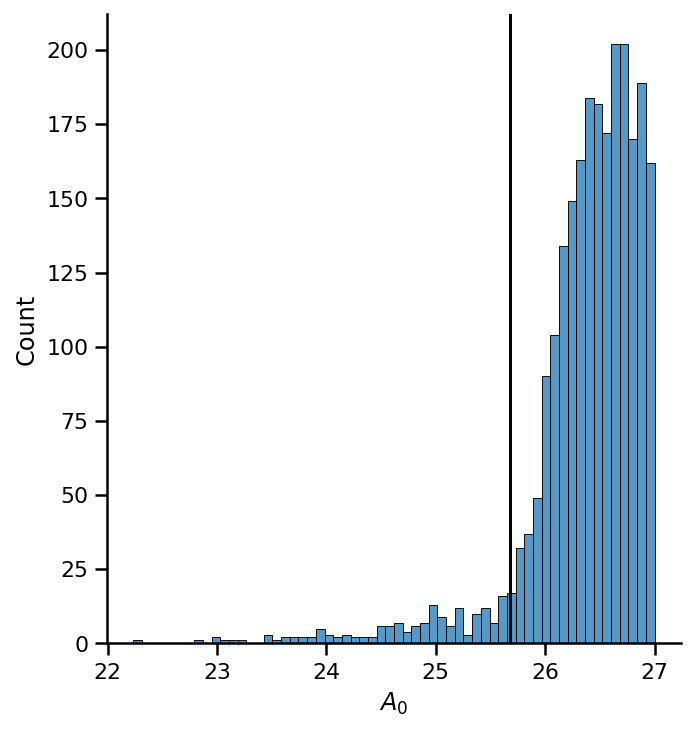

In [6]:
sns.displot(Aobs[:,0])
plt.xlabel(r'$A_0$')
plt.axvline(edge_centered, color='k')

And the "rectified" (i.e. "color corrected") $A_0$ photometry, which shows a bit sharper edge:

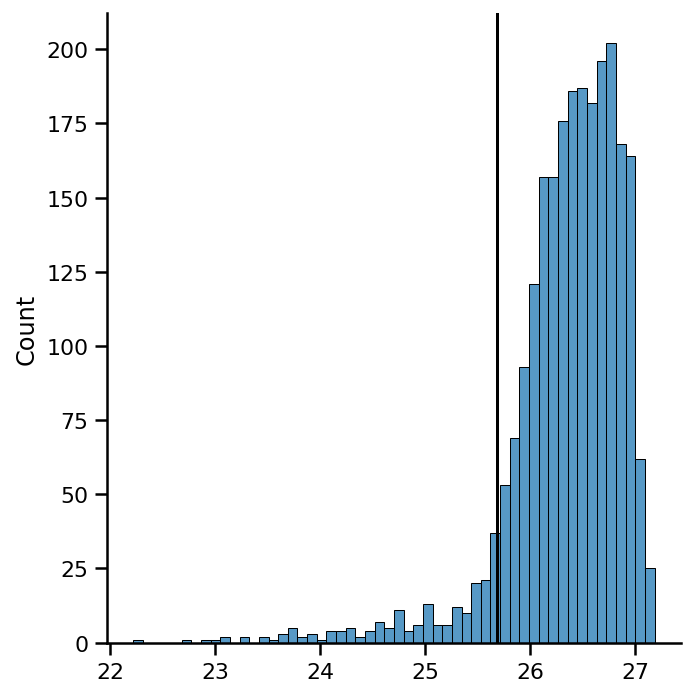

In [7]:
eobs = Aobs[:, 0] + (Aobs[:, 1]-Aobs[:, 0] - c_centered)*c
sigma_eobs = np.sqrt(np.sum(w[None,:]*w[None,:]*sigma_obs*sigma_obs, axis=1))

sns.displot(eobs)
plt.axvline(edge_centered, color='k')

In [8]:
num_chains=4
thin=1

sampler = NUTS(edge_model, dense_mass=True)
mcmc = MCMC(sampler, num_warmup=thin*1000, num_samples=thin*1000, thinning=thin, num_chains=num_chains)
mcmc.run(jax_prng_key(), Aobs, sigma_obs, A0_cut, e_center_mu=e_mu, e_center_sigma=e_sigma, c_mu=c_mu, c_sigma=c_sigma, c_center=c_centered)
trace = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'e_centered'}>,
        <AxesSubplot:title={'center':'e_centered'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'mu_bg'}>,
        <AxesSubplot:title={'center':'mu_bg'}>],
       [<AxesSubplot:title={'center':'scale_bg'}>,
        <AxesSubplot:title={'center':'scale_bg'}>]], dtype=object)

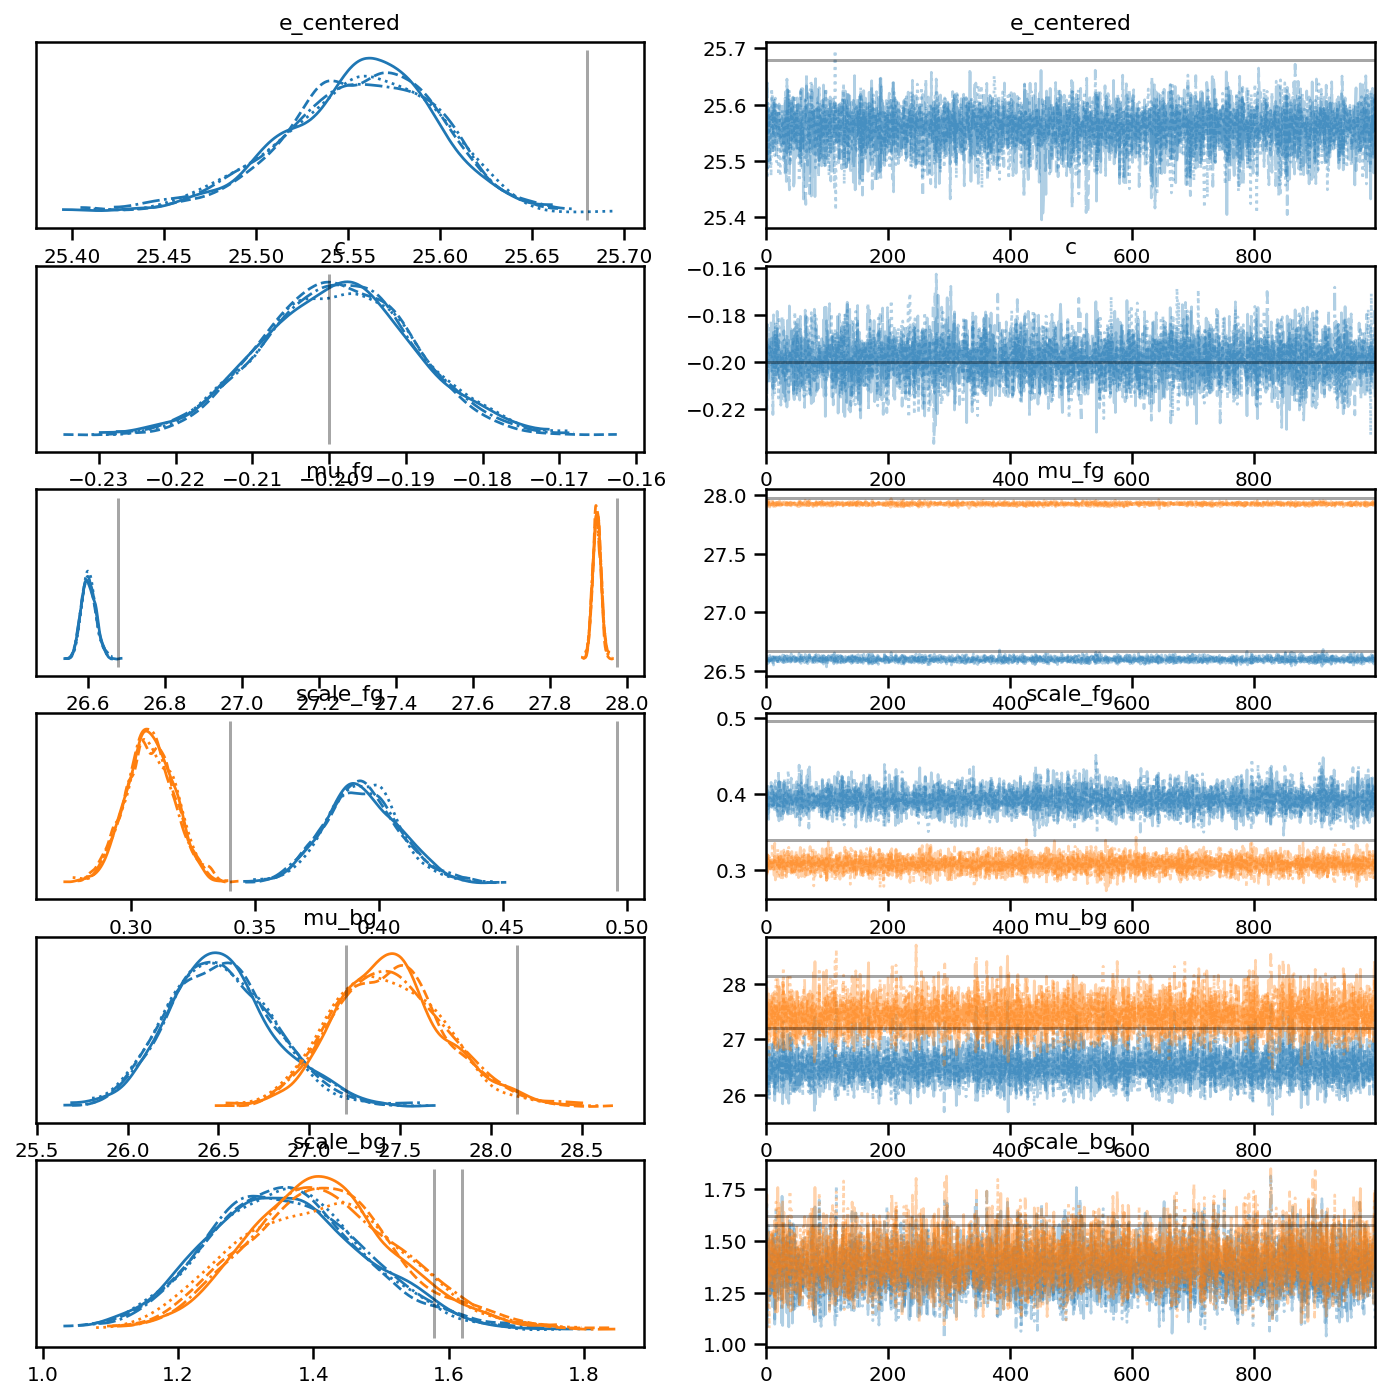

In [9]:
az.plot_trace(trace, var_names=['e_centered', 'c', 'mu_fg', 'scale_fg', 'mu_bg', 'scale_bg'],
              lines=[('mu_fg', {}, mu_fg), ('e_centered', {}, edge_centered), ('c', {}, c), ('scale_fg', {}, scale_fg), ('mu_bg', {}, mu_bg), ('scale_bg', {}, scale_bg)])

Looks like initialization could be still an issue, so the cell below is set up to exclude some chains that have gone wrong.  Edit the `good_chains` variable to point to the indices of the chains that are OK.

In [10]:
trace.posterior.e_centered.mean(axis=1)

<xarray.DataArray 'e_centered' (chain: 4)>
array([25.55595344, 25.55615738, 25.55735037, 25.55601721])
Coordinates:
  * chain    (chain) int64 0 1 2 3

array([[<AxesSubplot:title={'center':'e_centered'}>,
        <AxesSubplot:title={'center':'e_centered'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'mu_bg'}>,
        <AxesSubplot:title={'center':'mu_bg'}>],
       [<AxesSubplot:title={'center':'scale_bg'}>,
        <AxesSubplot:title={'center':'scale_bg'}>]], dtype=object)

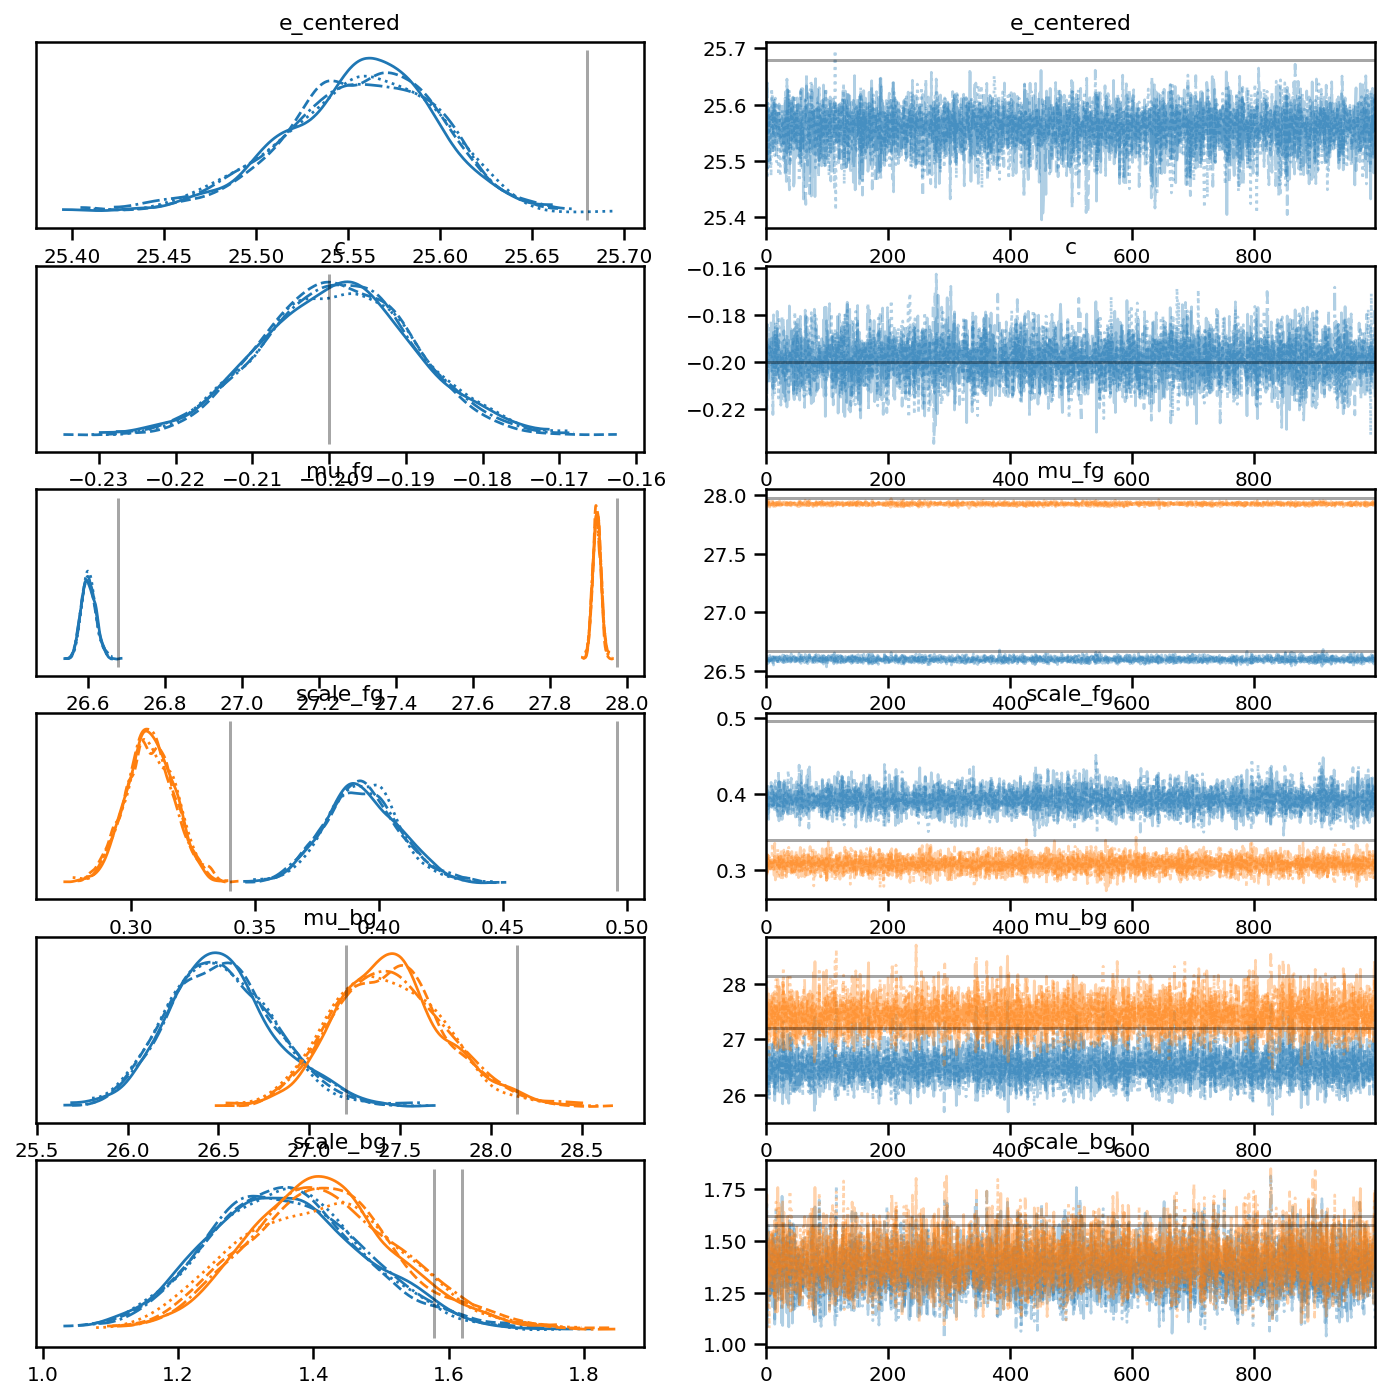

In [11]:
good_chains=[0,1,2,3]
az.plot_trace(trace, var_names=['e_centered', 'c', 'mu_fg', 'scale_fg', 'mu_bg', 'scale_bg'],
              lines=[('mu_fg', {}, mu_fg), ('e_centered', {}, edge_centered), ('c', {}, c), ('scale_fg', {}, scale_fg), ('mu_bg', {}, mu_bg), ('scale_bg', {}, scale_bg)],
              coords={'chain': good_chains})

In [12]:
trace = az.from_numpyro(mcmc)
az.summary(trace, var_names=['e_centered', 'c','mu_fg', 'cov_fg', 'mu_bg', 'cov_bg'], coords={'chain': good_chains})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
e_centered,25.556,0.041,25.476,25.629,0.001,0.000,7183.0,2542.0,1.0
c[0],-0.199,0.010,-0.216,-0.180,0.000,0.000,8136.0,3213.0,1.0
mu_fg[0],26.602,0.019,26.565,26.636,0.000,0.000,7681.0,3211.0,1.0
mu_fg[1],27.923,0.011,27.904,27.944,0.000,0.000,7568.0,2874.0,1.0
"cov_fg[0, 0]",0.155,0.012,0.132,0.177,0.000,0.000,7152.0,3218.0,1.0
"cov_fg[0, 1]",0.046,0.006,0.035,0.057,0.000,0.000,7415.0,2648.0,1.0
"cov_fg[1, 0]",0.046,0.006,0.035,0.057,0.000,0.000,7415.0,2648.0,1.0
"cov_fg[1, 1]",0.095,0.006,0.083,0.106,0.000,0.000,7039.0,3137.0,1.0
mu_bg[0],26.520,0.290,25.993,27.072,0.004,0.003,6413.0,3088.0,1.0
mu_bg[1],27.442,0.304,26.861,27.997,0.004,0.003,6475.0,3293.0,1.0


Text(0.5, 0, '$A_1 - A_0$')

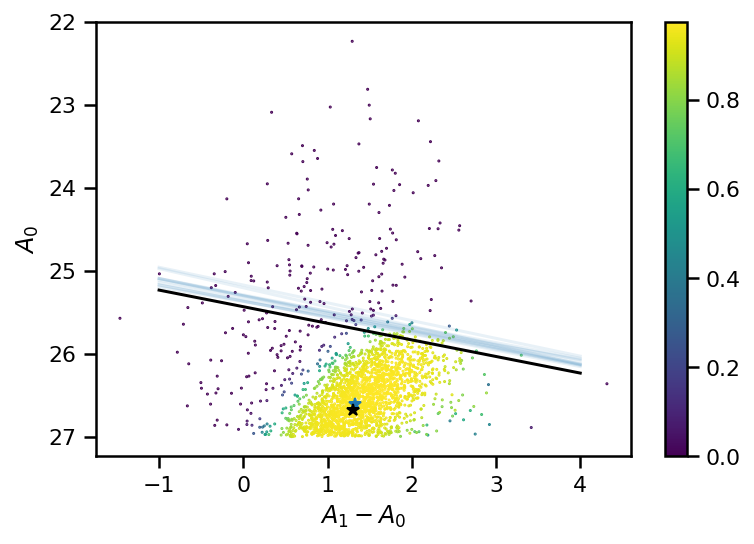

In [14]:
plt.scatter(Aobs[:,1]-Aobs[:,0], Aobs[:,0], c=np.exp(trace.posterior.log_fg_prob[good_chains,:,:].mean(axis=(0,1))), marker='.', s=1)
yl, yh = plt.ylim()
plt.ylim(yh, yl)
plt.colorbar()

cs = np.linspace(-1, 4, 1024)
for _ in range(10):
    c = np.random.choice(good_chains)
    d = np.random.choice(trace.posterior.draw)
    plt.plot(cs, trace.posterior.e_centered[c,d].values - trace.posterior.c[c,d,0].values*(cs - c_centered), color=sns.color_palette()[0], alpha=0.1)
plt.plot(cs, edge_centered - c_mu*(cs-c_centered), color='k')

mm = trace.posterior.mu_fg[good_chains,:,:].mean(axis=(0,1))
plt.plot(mm[1]-mm[0], mm[0], '*', color=sns.color_palette()[0])
plt.plot(mu_fg[1]-mu_fg[0], mu_fg[0], '*', color='k')

plt.ylabel(r'$A_0$')
plt.xlabel(r'$A_1 - A_0$')

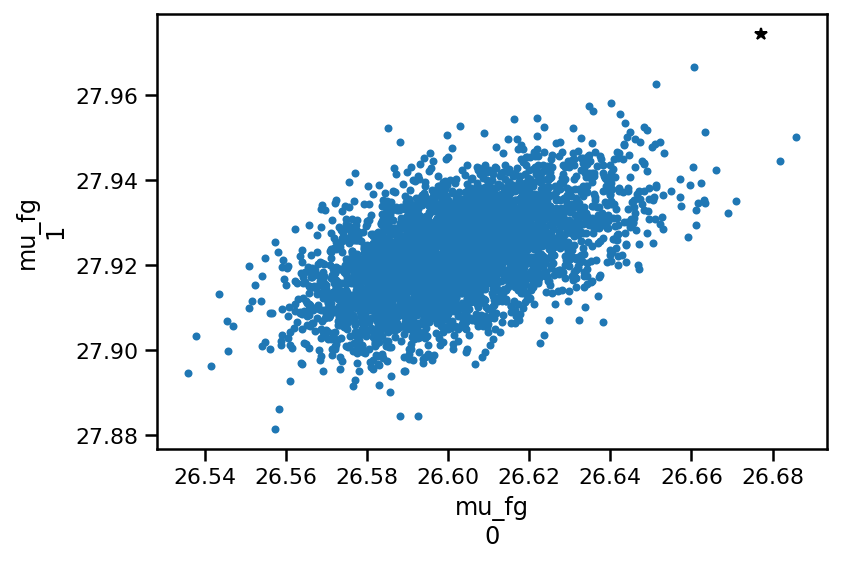

In [15]:
ax = az.plot_pair(trace, var_names='mu_fg', coords={'chain': good_chains})
ax.plot(mu_fg[0], mu_fg[1], '*k')